In [3]:
#!/usr/bin/python
import csv
import time
import json
import talib
import requests
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, date, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [4]:
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.bitbank.cc'
pair = 'btc_jpy'
period = '1min'

today = datetime.today()
yesterday = today - timedelta(days=1)
today = "{0:%Y%m%d}".format(today)
yesterday = "{0:%Y%m%d}".format(yesterday)

In [5]:
def api_ohlcv(timestamp):
    api_url = '{0}/{1}/candlestick/{2}/{3}'.format(api_url_base, pair, period, timestamp)
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        ohlcv = json.loads(response.content.decode('utf-8'))['data']['candlestick'][0]['ohlcv']
        return ohlcv
    else:
        return None

In [6]:
ohlcv = api_ohlcv('20190901')
open, high, low, close, volume, timestamp = [],[],[],[],[],[]
for i in ohlcv:
    open.append(int(i[0]))
    high.append(int(i[1]))
    low.append(int(i[2]))
    close.append(int(i[3]))
    volume.append(float(i[4]))
    time_str = str(i[5])
    timestamp.append(datetime.fromtimestamp(int(time_str[:10])).strftime('%Y/%m/%d %H:%M:%M'))

date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
df = pd.DataFrame({'open': open, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=date_time_index)
# df.index += pd.offsets.Hour(9) # adjustment for JST
print(df.shape)
print(df.columns)

(1440, 5)
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


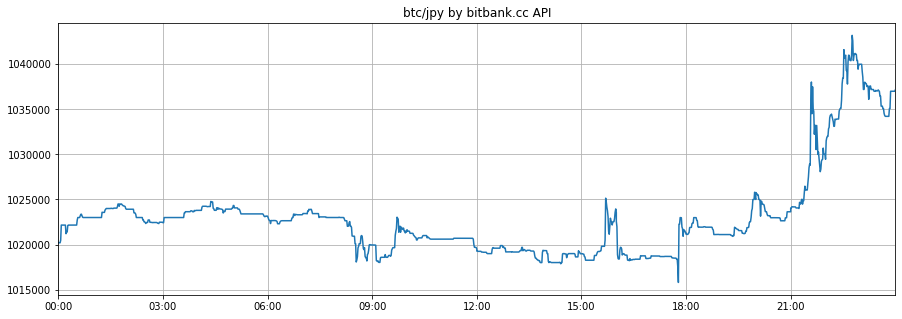

In [7]:
def draw(df):
    df1 = df.copy()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('btc/jpy by bitbank.cc API')
    ax.plot(df1.index, df1.close,label="original")
    ax.set_xlim(df1.index[0], df1.index[-1])
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.grid()
    
draw(df)

----------------------------------------------------------------------------------------
X shape: (1440,5)
y shape: (1440,1)
----------------------------------------------------------------------------------------
y
-1     172
 0    1092
 1     176
dtype: int64
y=1 up, y=0 stay, y=-1 down
----------------------------------------------------------------------------------------


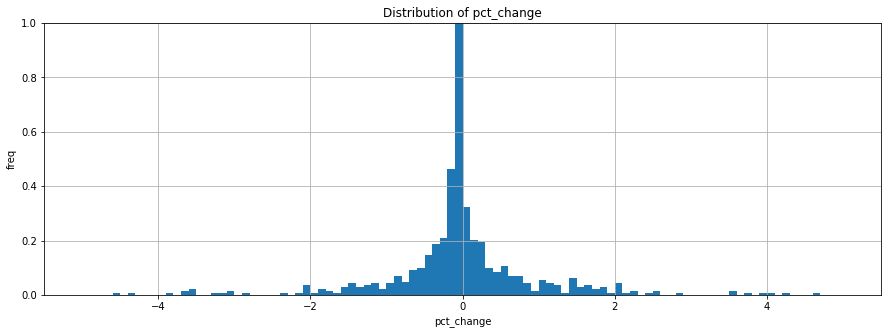

In [8]:
# pct_change
f = lambda x: 1 if x>0.0001 else -1 if x<-0.0001 else 0 if -0.0001<=x<=0.0001 else np.nan
y = df.rename(columns={'close': 'y'}).loc[:, 'y'].pct_change(1).shift(-1).fillna(0)
X = df.copy()
y_ = pd.DataFrame(y.map(f), columns=['y'])
df_ = pd.concat([df, y_], axis=1)

# check the shape
print('----------------------------------------------------------------------------------------')
print('X shape: (%i,%i)' % X.shape)
print('y shape: (%i,%i)' % y_.shape)
print('----------------------------------------------------------------------------------------')
print(y_.groupby('y').size())
print('y=1 up, y=0 stay, y=-1 down')
print('----------------------------------------------------------------------------------------')
t_bool = df_['y'] == 1
f_bool = df_['y'] == -1
pd.set_option('display.max_rows', 200)

# histgram drawing
y_std = (y - y.mean())/y.std() # Standalization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Distribution of pct_change')
ax.set_xlabel('pct_change')
ax.set_ylabel('freq')
ax.set_ylim(0, 1.0)
ax.hist(y_std, bins=100, range=(-5,5), density=True)
ax.grid()

In [44]:
df_[t_bool]

,open,high,low,close,volume,y
2019-09-01 00:03:03,1020201,1020201,1020201,1020201,0.0004,1
2019-09-01 00:04:04,1020200,1020478,1020200,1020478,1.0640,1
2019-09-01 00:13:13,1021605,1021605,1021141,1021205,0.0495,1
2019-09-01 00:15:15,1021405,1021405,1021405,1021405,0.0220,1
2019-09-01 00:31:31,1022163,1022163,1022163,1022163,0.0591,1
2019-09-01 00:32:32,1022163,1022722,1022163,1022722,0.1090,1
2019-09-01 00:36:36,1023000,1023000,1023000,1023000,0.0004,1
2019-09-01 00:37:37,1023183,1023184,1023183,1023184,0.2001,1
2019-09-01 01:14:14,1023001,1023001,1023001,1023001,0.0926,1
2019-09-01 01:19:19,1023570,1023570,1023570,1023570,0.0107,1


In [45]:
df_[f_bool]

,open,high,low,close,volume,y
2019-09-01 00:12:12,1022163,1022163,1022159,1022159,0.0579,-1
2019-09-01 00:39:39,1023353,1023372,1023353,1023372,0.3321,-1
2019-09-01 00:40:40,1023352,1023352,1023209,1023209,0.0004,-1
2019-09-01 01:43:43,1024500,1024500,1024500,1024500,0.0511,-1
2019-09-01 01:54:54,1024250,1024250,1024224,1024224,0.1759,-1
2019-09-01 02:09:09,1023920,1023920,1023920,1023920,0.1469,-1
2019-09-01 02:12:12,1023498,1023498,1023485,1023485,0.0003,-1
2019-09-01 02:13:13,1023354,1023354,1023354,1023354,0.0002,-1
2019-09-01 02:24:24,1023000,1023000,1023000,1023000,0.0109,-1
2019-09-01 02:26:26,1022724,1022724,1022724,1022724,0.0120,-1


In [9]:
X['diff1'] = X.close - X.open
X['diff2'] = X.high - X.low
X_ = X.drop(['open', 'high', 'low'], axis=1)
X_.join(y_).head(200)

,close,volume,diff1,diff2,y
2019-09-01 00:00:00,1020201,0.0001,0,0,0
2019-09-01 00:01:01,1020201,0.0000,0,0,0
2019-09-01 00:02:02,1020201,0.0000,0,0,0
2019-09-01 00:03:03,1020201,0.0004,0,0,1
2019-09-01 00:04:04,1020478,1.0640,278,278,1
2019-09-01 00:05:05,1022162,1.5353,1684,1684,0
2019-09-01 00:06:06,1022163,0.0101,1,1,0
2019-09-01 00:07:07,1022163,0.0001,0,0,0
2019-09-01 00:08:08,1022162,0.3106,0,0,0
2019-09-01 00:09:09,1022163,0.2599,1,1,0


close       int64
volume    float64
diff1       int64
diff2       int64
y           int64
dtype: object
 0    1092
 1     176
-1     172
Name: y, dtype: int64


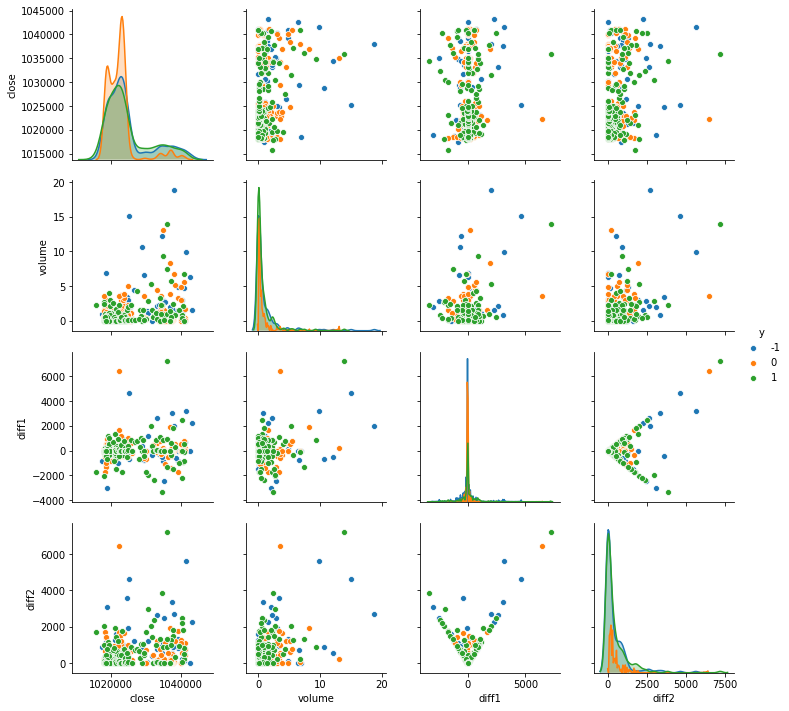

In [10]:
# seaborn plot
import seaborn as sns
df_ml = X_.join(y_)
print(df_ml.dtypes)
print(df_ml['y'].value_counts())
sns.pairplot(df_ml, hue='y', vars=['close', 'volume', 'diff1', 'diff2'])

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

pipe_knn = Pipeline([('scl', StandardScaler()), ('est', KNeighborsClassifier(n_neighbors=3))])
pipe_logistic = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=39))])
pipe_rf = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(random_state=39))])
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])

pipe_names = ['KNN','Logistic','RandomForest','GradientBoosting']
pipe_lines = [pipe_knn, pipe_logistic, pipe_rf, pipe_gb]

for (i, pipe) in enumerate(pipe_lines):
    pipe.fit(X_train, y_train.values.ravel())
    print('%s: %.3f' % (pipe_names[i] + ' Train Accuracy', accuracy_score(y_train.values.ravel(), pipe.predict(X_train))))
    print('%s: %.3f' % (pipe_names[i] + ' Test Accuracy', accuracy_score(y_test.values.ravel(), pipe.predict(X_test))))
    print('%s: %.3f' % (pipe_names[i] + ' Train F1 Score', f1_score(y_train.values.ravel(), pipe.predict(X_train), average='weighted')))
    print('%s: %.3f' % (pipe_names[i] + ' Test F1 Score', f1_score(y_test.values.ravel(), pipe.predict(X_test), average='weighted')))

X_train shape: (964, 4)
X_test shape: (476, 4)
y_train shape: (964, 1)
y_test shape: (476, 1)
KNN Train Accuracy: 0.817
KNN Test Accuracy: 0.689
KNN Train F1 Score: 0.796
KNN Test F1 Score: 0.645
Logistic Train Accuracy: 0.769
Logistic Test Accuracy: 0.750
Logistic Train F1 Score: 0.698
Logistic Test F1 Score: 0.664
RandomForest Train Accuracy: 0.974
RandomForest Test Accuracy: 0.693
RandomForest Train F1 Score: 0.973
RandomForest Test F1 Score: 0.652


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GradientBoosting Train Accuracy: 0.882
GradientBoosting Test Accuracy: 0.748
GradientBoosting Train F1 Score: 0.867
GradientBoosting Test F1 Score: 0.695


In [17]:
df_ = df.copy()
df_.columns = ['Close','Open','High','Low','Volume']
print(df_.columns)
df_.head(10)

Index(['Close', 'Open', 'High', 'Low', 'Volume'], dtype='object')


,Close,Open,High,Low,Volume
2019-09-01 00:00:00,1020201,1020201,1020201,1020201,0.0001
2019-09-01 00:01:01,1020201,1020201,1020201,1020201,0.0000
2019-09-01 00:02:02,1020201,1020201,1020201,1020201,0.0000
2019-09-01 00:03:03,1020201,1020201,1020201,1020201,0.0004
2019-09-01 00:04:04,1020200,1020478,1020200,1020478,1.0640
2019-09-01 00:05:05,1020478,1022162,1020478,1022162,1.5353
2019-09-01 00:06:06,1022162,1022163,1022162,1022163,0.0101
2019-09-01 00:07:07,1022163,1022163,1022163,1022163,0.0001
2019-09-01 00:08:08,1022162,1022162,1022162,1022162,0.3106
2019-09-01 00:09:09,1022162,1022163,1022162,1022163,0.2599


In [103]:
from backtesting import Strategy
from backtesting.lib import crossover

def RF_Backtesting(df):
    """
    Return the label from calculating df(close, volume, diff1, diff2), at
    each step taking into account `n` previous values.
    """
    return pipe_rf.predict(df)

def GB_Backtesting(df):
    """
    Return the label from calculating df(close, volume, diff1, diff2), at
    each step taking into account `n` previous values.
    """
    return pipe_gb.predict(df)

class MachineLearning(Strategy):
    
    def init(self):
        # Precompute a label for data
        close = pd.DataFrame({'Close': self.data.Close})
        open = pd.DataFrame({'Open': self.data.Open})
        high = pd.DataFrame({'High': self.data.High})
        low = pd.DataFrame({'Low': self.data.Low})
        volume = pd.DataFrame({'Volume': self.data.Volume})
        self.df = close.join(open).join(high).join(low).join(volume)
        self.df['diff1'] = self.df['Close'] - self.df['Open']
        self.df['diff2'] = self.df['High'] - self.df['Low']
        self.label = self.I(GB_Backtesting, self.df.drop(['Open', 'High', 'Low'], axis=1))
        # self.label = self.I(RF_Backtesting, self.df.drop(['Open', 'High', 'Low'], axis=1))
    
    def next(self):
        if self.label == 1:
            self.buy()
        elif self.label == -1:
            self.sell()

In [104]:
from backtesting import Backtest

bt = Backtest(df_, MachineLearning, cash=1, commission=.002)
bt.run()

Start                     2019-09-01 00:00:00
End                       2019-09-01 23:59:59
Duration                      0 days 23:59:59
Exposure [%]                          98.3761
Equity Final [$]                     0.873191
Equity Peak [$]                             1
Return [%]                           -12.6809
Buy & Hold Return [%]                 1.64673
Max. Drawdown [%]                    -12.7409
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                   80
Win Rate [%]                            11.25
Best Trade [%]                       0.759737
Worst Trade [%]                     -0.839769
Avg. Trade [%]                      -0.167007
Max. Trade Duration           0 days 05:48:49
Avg. Trade Duration           0 days 00:17:43
Expectancy [%]                       0.217416
SQN                                  -7.46218
Sharpe Ratio                      